In [25]:
import pybammeis
import pybamm as pb
import os
import re
import numpy as np
from gamry_parser import GamryParser, Impedance
import pandas as pd
import time as timer
import matplotlib.pyplot as plt
from scipy.fft import fft
import random
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.interpolate import interp1d
import pyswarms as ps 
from pyswarms.single import GlobalBestPSO
import datetime
from scibatt.config import COLUMN_NAMES, CURRENT_ZERO_TOLERANCE

Define parameters

In [26]:
def MJ1_ocp_tanh_SiC(sto):
    x = sto
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    
    return (
            p[0] * pb.exp(-p[1] * x)
            + p[2]
            - p[3] * pb.tanh(p[4] * (x - p[5]))
            - p[6] * pb.tanh(p[7] * (x - p[8]))
            - p[9] * pb.tanh(p[10] * (x - p[11]))
        )

def MJ1_ocp_tanh_NMC(sto):
    x = sto
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])

    return (
            -p[0] * x
            + p[1]
            - p[2] * pb.tanh(p[3] * (x - p[4]))
            - p[5] * pb.tanh(p[6] * (x - p[7]))
            + p[8] * pb.tanh(p[9] * (x - p[10]))
        )

# Parameters from literature
literature_params = {
    'Electrode height [m]': 0.059,
    'Electrode width [m]': 0.610*2, # Multiplying by two since the electrode has active material on both sides.
    'Lower voltage cut-off [V]': 2.5,
    'Upper voltage cut-off [V]': 4.5,
    'Nominal cell capacity [A.h]': 3.5,

    # From Table 3 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Maximum concentration in negative electrode [mol.m-3]': 32418.5,
    'Negative particle radius [m]': 6.1e-06,
    'Negative electrode porosity': 0.216,
    'Negative electrode active material volume fraction': 0.7011854763922494,
    'Negative electrode conductivity [S.m-1]': 100.0,
    'Negative electrode diffusivity [m2.s-1]': 5e-14,
    'Negative electrode OCP [V]': MJ1_ocp_tanh_SiC,

    # 'Maximum concentration in positive electrode [mol.m-3]': 51081.15,
    'Positive particle radius [m]': 3.8e-06,
    'Positive electrode porosity': 0.171,
    'Positive electrode active material volume fraction': 0.7355902286855152,
    'Positive electrode conductivity [S.m-1]': 0.17,
    'Positive electrode diffusivity [m2.s-1]': 5e-13,
    'Positive electrode OCP [V]': MJ1_ocp_tanh_NMC,

    'Separator porosity': 0.45,

    # end of section 3 data
    
    # From Table A-9 and A-10 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Negative current collector conductivity [S.m-1]': 5.9e7/(1+3.383e-3 * (298.15-293.15)), 
    'Negative current collector thickness [m]': 11e-06,
    'Negative current collector density [kg.m-3]': 8950.0,
    'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
    'Negative current collector thermal conductivity [W.m-1.K-1]': 398.0,
    'Negative electrode density [kg.m-3]': 2242.0,
    'Negative electrode specific heat capacity [J.kg-1.K-1]': 867.0,
    'Negative electrode thermal conductivity [W.m-1.K-1]': 1.04,
    'Negative electrode thickness [m]': 86.7e-6, # 86.7 in Sturm 2019, 85um in Heenan2020, 170um in NASA
    'Positive current collector conductivity [S.m-1]': 3.78e7/(1+4.290e-3 * (298.15-293.15)),
    'Positive current collector density [kg.m-3]': 2710.0,
    'Positive current collector specific heat capacity [J.kg-1.K-1]': 903.0,
    'Positive current collector thermal conductivity [W.m-1.K-1]': 238.0,
    'Positive current collector thickness [m]': 17.3e-06,
    'Positive electrode density [kg.m-3]': 4870.0,
    'Positive electrode specific heat capacity [J.kg-1.K-1]': 840.1,
    'Positive electrode thermal conductivity [W.m-1.K-1]': 1.58,
    'Positive electrode thickness [m]': 66.2e-6, #66.2um in Sturm2019, 72.5um in Heenan2020, 160um in NASA
    'Separator density [kg.m-3]': 1009.0,
    'Separator specific heat capacity [J.kg-1.K-1]': 1978.2,
    'Separator thermal conductivity [W.m-1.K-1]': 0.33,
    'Separator thickness [m]': 12e-06,
    # end of table data
    "Current function [A]": 0.7
    }

# Use default parameters from the Chen2020 publication
params = pb.ParameterValues("Chen2020")

# Overwrite parameters with our own
for parameter, value in literature_params.items():
    try:
        if params[parameter] != value:
            params[parameter] = value
    except KeyError as e:
        print(f"Parameter {parameter} not part of default. Skipping.")



In [27]:



def read_txt(filepath, raw = False):
    """
    Reads a maccor datafile and returns a dict of of dataframes;
    The key being the standard filename, and the dataframe being the data for each step in the programme
    """
    maccor_data_format = 2013 # The year of the format

    # This reads the csv file with some extra options
    with open(filepath, "r") as f:
        header_line_num = None
        for i, line in enumerate(f.readlines()):
            if line.startswith("Rec\tCycle"):
                header_line_num = i
                if "Cycle P" in line:
                    maccor_data_format = 2023
                break
        if not header_line_num:
            raise Exception(
                f"Could not find headerline in Maccor datafile: {filepath}"
            )  # TODO: Convert to custom exception

    cycle_col_name = "Cycle P" if maccor_data_format == 2023 else "Cycle"

    df = pd.read_csv(
        filepath,
        usecols=[cycle_col_name, "DPT Time", "Current", "Voltage", "Capacity", "Step", "MD"],
        encoding="UTF-8",
        header=header_line_num,
        delimiter="\t",
    )

    # Modifying time
    def convert_timestamp_to_unix_epoch(timestamp_str):
        try:
            timestamp_format = "%d.%m.%Y %H:%M:%S"
            datetime_obj = datetime.datetime.strptime(timestamp_str, timestamp_format)
        except:
            try:
                timestamp_format = "%d/%m/%Y %H:%M:%S"
                datetime_obj = datetime.datetime.strptime(timestamp_str, timestamp_format)
            except:
                try:
                    timestamp_format = "%m/%d/%Y %H:%M:%S"
                    datetime_obj = datetime.datetime.strptime(timestamp_str, timestamp_format)
                except Exception as e:
                    print(f"Cannot parse datetime format in maccor reader. Error: {e}")


        return datetime_obj.timestamp()  # Returns unix epoch float

    df[COLUMN_NAMES["TIME"]] = df["DPT Time"].apply(
        lambda x: convert_timestamp_to_unix_epoch(x)
    )

    # Making sure negative currents are negative
    df.loc[df["MD"] == "D", "Current"] *= -1

    # Rename columns to match spec
    df.rename(
        columns={
            "Current": COLUMN_NAMES["CURRENT"],
            "Voltage": COLUMN_NAMES["VOLTAGE1"],
            cycle_col_name: "Cycle",
        },
        inplace=True,
    )

    # TODO: This really does not fit into the system. The whole data storage system should be changed probably.
    # Was done to be able to get the raw data and print it.
    if raw:
        return df

    # Group by step to separate steps
    groups_step = df.groupby("Step")

    # Scan groups and add to return dict
    data = {}
    tol = CURRENT_ZERO_TOLERANCE
    for num, group_df in groups_step:
        mean_current = group_df[COLUMN_NAMES["CURRENT"]].mean()
        timestamp = group_df[COLUMN_NAMES["TIME"]].iloc[0]

        # Remove columns we don't want
        required_columns = [
            COLUMN_NAMES["TIME"],
            COLUMN_NAMES["CURRENT"],
            COLUMN_NAMES["VOLTAGE1"],
        ]
        group_df = group_df.drop(
            columns=[col for col in df if col not in required_columns]
        )

        if -tol < mean_current < tol:
            data[f"{timestamp}_cycling_p000.000A"] = group_df
        elif mean_current > tol:
            data[f"{timestamp}_cycling_p{mean_current:08.4f}A"] = group_df
        elif mean_current < tol:
            data[f"{timestamp}_cycling_n{mean_current:08.4f}A"] = group_df

    return data

def read_csv(filepath, raw = False):
    """
    Reads a maccor datafile exported using the MaccorExport2.exe, selecting CSV export, and the following columns: 
    Cycle P,Cycle C,Step,Test Time,Step Time,Capacity (AHr),Energy (WHr),Current (A),Voltage (V),MD,ES,DPT Time
    
    Returns a dict of of dataframes;
    The key being the standard filename, and the dataframe being the data for each step in the programme
    """
    # This reads the csv file with some extra options
    with open(filepath, "r") as f:
        header_line_num = None
        for i, line in enumerate(f.readlines()):
            if line.startswith("Rec,Cycle"):
                header_line_num = i
                break
        if not header_line_num:
            raise Exception(
                f"Could not find headerline in Maccor datafile: {filepath}"
            )  # TODO: Convert to custom exception

    df = pd.read_csv(
        filepath,
        usecols=["Cycle P", "DPT Time", "Current (A)", "Voltage (V)", "Capacity (AHr)", "Step", "MD"],
        encoding="UTF-8",
        header=header_line_num,
        delimiter=",",
    )

    # Modifying time
    format_string = "%m/%d/%Y %I:%M:%S %p"
    df['t'] = pd.to_datetime(df['DPT Time'], format='mixed')
    df['t'] = df['t'].apply(lambda x: x.timestamp())
    # df["t"] = df["DPT Time"].apply(lambda x: datetime.datetime.strptime(x, format_string).timestamp())

    # Making sure negative currents are negative
    df.loc[df["MD"] == "D", "Current (A)"] *= -1

    # Rename columns to match spec
    df.rename(
        columns={
            "Current (A)": COLUMN_NAMES["CURRENT"],
            "Voltage (V)": COLUMN_NAMES["VOLTAGE1"],
            "Cycle P": "Cycle",
        },
        inplace=True,
    )

    # TODO: This really does not fit into the system. The whole data storage system should be changed probably.
    # Was done to be able to get the raw data and print it.
    if raw:
        return df

    # Group by step to separate steps
    groups_step = df.groupby("Step")

    # Scan groups and add to return dict
    data = {}
    tol = CURRENT_ZERO_TOLERANCE
    for num, group_df in groups_step:
        mean_current = group_df[COLUMN_NAMES["CURRENT"]].mean()
        timestamp = group_df[COLUMN_NAMES["TIME"]].iloc[0]

        # Remove columns we don't want
        required_columns = [
            COLUMN_NAMES["TIME"],
            COLUMN_NAMES["CURRENT"],
            COLUMN_NAMES["VOLTAGE1"],
        ]
        group_df = group_df.drop(
            columns=[col for col in df if col not in required_columns]
        )

        if -tol < mean_current < tol:
            data[f"{timestamp}_cycling_p000.000A"] = group_df
        elif mean_current > tol:
            data[f"{timestamp}_cycling_p{mean_current:08.4f}A"] = group_df
        elif mean_current < tol:
            data[f"{timestamp}_cycling_n{mean_current:08.4f}A"] = group_df

    return data

Load experimental data

In [32]:
M1_01 = read_txt('/Users/synnemard/Desktop/lithium_ion/EIS_data/data-acq/MJ1_01_data-acq_01.014.txt')
print(M1_01)
M1_03 = read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/data-acq/MJ1_01_data-acq_03.016.csv')

{'1710841208.0_cycling_p000.000A':       I     U1             t
0   0.0  2.152  1.710841e+09
1   0.0  3.299  1.710841e+09
2   0.0  3.299  1.710841e+09
3   0.0  3.299  1.710841e+09
4   0.0  3.299  1.710841e+09
..  ...    ...           ...
56  0.0  3.299  1.710841e+09
57  0.0  3.299  1.710841e+09
58  0.0  3.299  1.710841e+09
59  0.0  3.299  1.710841e+09
60  0.0  3.299  1.710841e+09

[61 rows x 3 columns], '1710841268.0_cycling_n-00.1594A':          I     U1             t
61  -0.000  3.298  1.710841e+09
62  -0.097  3.294  1.710841e+09
63  -0.150  3.291  1.710841e+09
64  -0.161  3.289  1.710841e+09
65  -0.161  3.287  1.710841e+09
..     ...    ...           ...
204 -0.161  3.007  1.710846e+09
205 -0.161  3.005  1.710846e+09
206 -0.161  3.003  1.710846e+09
207 -0.161  3.001  1.710846e+09
208 -0.161  3.000  1.710846e+09

[148 rows x 3 columns], '1710845760.0_cycling_p000.6420A':          I     U1             t
209  0.643  3.042  1.710846e+09
210  0.642  3.051  1.710846e+09
211  0.642  3.055 

Plot experimental data

[2.152 3.299 3.299 ... 3.    3.    3.   ]


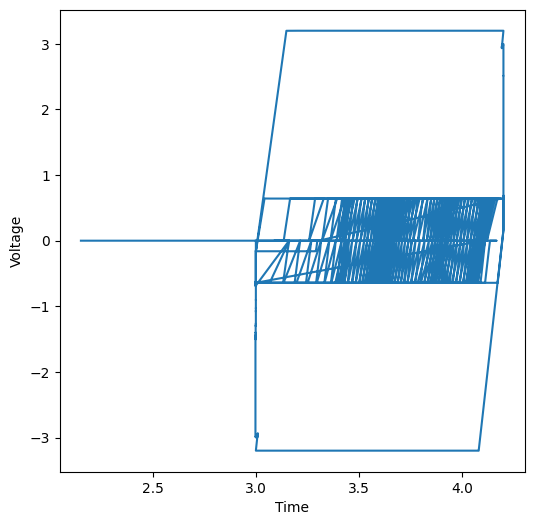

In [63]:
u1 = np.array(M1_01['1710841208.0_cycling_p000.000A']['U1'])
t1 = np.array(M1_01['1710841208.0_cycling_p000.000A']['t'])

u2 = np.array(M1_01['1710841268.0_cycling_n-00.1594A']['U1'])
t2 = np.array(M1_01['1710841268.0_cycling_n-00.1594A']['t'])

def extract_data(dict): 
    U = []
    I = []
    for key, value in dict.items(): 
        u = np.array(dict[key]['U1'])
        #u = dict[key]['U1']
        #print(u)
        #print(len(u))
        i = np.array(dict[key]['I'])
        #print(t)
        #print(len(t))
        U.append(u)
        I.append(i)
    V = np.concatenate(U)
    A = np.concatenate(I)
    print(V)
    return V, A

V, A = extract_data(M1_01)

def plotting(x, y): 
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.plot(x,y)
    #ax.plot(t2,u2)
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    return plt.show()

plotting(V,A)

In [29]:



class GalvanoStatic:
    def __init__(self, title="Galvanostatic", style=None):
        if style:
            if style == "Evyon":
                from eir_visualize import EvyonStyle

                self.fig, self.ax = EvyonStyle().__enter__()
        else:
            self.fig, self.ax = plt.subplots(nrows=1, ncols=1)
        # self.fig.suptitle(suptitle) # This is figure title, not axis
        self.ax.set(
            title=title,
            # ylabel = 'Potential [V]',
            # xlabel = 'Specific Capacity [mAh]',
            # ylim = (2.5,5),
            # xlim = (0, 150),
            # xticks = (np.arange(0, 150), step=20)),
            # yticks = (np.arange(3, 5, step=0.2)),
        )
        self.fig.tight_layout()
        self.twinx = None

    def get_twinx(self):
        if not self.twinx:
            self.twinx = self.ax.twinx()
            return self.twinx
        else:
            return self.twinx

    def add_data(self, x, y1, y2=None, labely1=None, labely2=None, vistype="scatter"):
        dotsize = 2
        # Plot data
        if vistype == "scatter":
            self.ax.scatter(x, y1, label=labely1 if labely1 else "", s=dotsize)
        else:
            self.ax.plot(x, y1, label=labely1 if labely1 else "")
        if type(y2) == np.ndarray:
            if vistype == "scatter":
                self.get_twinx().scatter(
                    x, y2, label=labely2 if labely2 else "", s=dotsize, alpha=0.5
                )
            else:
                self.get_twinx().plot(
                    x, y2, label=labely2 if labely2 else "", linestyle="--"
                )

    def set_x(self, xlabel="Specific Capacity [mAh]"):
        self.ax.set_xlabel(xlabel)

    def set_y(self, ylabel="Potential, U [V]"):
        self.ax.set_ylabel(ylabel)

    def set_y2(self, ylabel="Current, I [A]"):
        self.get_twinx().set_ylabel(ylabel)

    def save(self, filename=None, format="svg"):
        format = format.strip(".")
        if filename and not filename.endswith(f".{format}"):
            filename += "." + format
        plt.savefig(
            filename if filename else f"plot.{format}",
            dpi=300,
            bbox_inches="tight",
            format=format,
        )

    def plot(self):
        plt.legend()
        plt.show()

In [15]:
# for example extract_data('.txt', 1, 4)

def extract_data(type, degrad, number): 
    file = '/Users/synnemard/Desktop/lithium_ion/EIS_data/data-acq/MJ1_01_data-acq_0'+str(degrad)+'.01'+str(number)+type
    if type == '.csv': 
        df = pd.read_csv(file, delimiter=',', skiprows=2)
        U = df['Voltage (V)']
        u_list = np.array(U)
        t = df['Test Time']
        t_list = np.array(t)
        
    else: 
        return 'sorry'
    
    return df
    #return u_list, t_list 

extract_data('.csv', 6, 0)
#u, t = extract_data('.csv', 6, 0)
#print(t)
#plt.plot(t,u)
#plt.xlabel('Time')
#plt.ylabel('Voltage')
#plt.show()




,Rec,Cycle P,Cycle C,Step,Test Time,Step Time,Capacity (AHr),Energy (WHr),Current (A),Voltage (V),MD,ES,DPT Time
0,1,0,1,1,0d 00:00:0,0d 00:00:0,0.000,0.000,0.000,3.182,R,0,8/7/2024 11:33:53 AM
1,2,0,1,1,0d 00:00:1,0d 00:00:1,0.000,0.000,0.000,3.401,R,1,8/7/2024 11:33:54 AM
2,3,0,1,1,0d 00:00:2,0d 00:00:2,0.000,0.000,0.000,3.401,R,1,8/7/2024 11:33:55 AM
3,4,0,1,1,0d 00:00:3,0d 00:00:3,0.000,0.000,0.000,3.401,R,1,8/7/2024 11:33:56 AM
4,5,0,1,1,0d 00:00:4,0d 00:00:4,0.000,0.000,0.000,3.401,R,1,8/7/2024 11:33:57 AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24809,24810,0,4,21,1d 17:44:37,0d 00:05:18,0.027,0.082,0.167,3.000,D,4,8/9/2024 5:18:36 AM
24810,24811,0,4,21,1d 17:44:42,0d 00:05:22,0.028,0.083,0.165,3.000,D,4,8/9/2024 5:18:41 AM
24811,24812,0,4,21,1d 17:44:45,0d 00:05:26,0.028,0.083,0.163,3.000,D,4,8/9/2024 5:18:44 AM
24812,24813,0,4,21,1d 17:44:52,0d 00:05:33,0.028,0.084,0.161,3.000,D,132,8/9/2024 5:18:51 AM


In [ ]:
def get_vdc(i, d): 
    length = get_exp_data(i, d)[2]
    file = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_01_EIS-SoC_01-05/MJ1_01_EIS-SoC_0"+str(i)+"/"+d+"EISGALV3V587.DTA"
    df = pd.read_csv(file, delimiter='\t', skiprows=[i for i in range(0, 60)])

    df_vdc = df['Vdc'][::-1]
    vdc = df_vdc[:length+1]
    v_list = np.array(vdc)

    sum = 0 
    for i in v_list: 
        sum += float(i) 
    v_avg = sum/len(v_list)

    return v_avg #, df_name]

pd.read_csv("/Users/synnemard/Desktop/lithium_ion/MJ1_01_01.csv")

df = pd.DataFrame()